# This notebook is set up to run multiple data files through developed pipeline that preprocesses data with modular functions, and train/tests multiple datasets against ML algorithms. One key feature of this notebook is the sentence semantic encoder which maps similar questions from dataset to datset allowing automatic mapping between old and future surveys.This notebook can do the train on one data set, test on another to show predictive capabilities of ML algorithms. The team developed tensor flow Boosted Tree Classifier, hyperparameter search on Random Forest, Gradient Boost and Xtreme Gradient Boost and finally Auto Keras. All ML Outputs have a report that shows the ROC curve, confusion matrix, statistical performance metrics and finally the feature importance visuals.

# Data for this notebook is stored in the Client Data directory of VTSD21's Google Drive and can be accessed when that folder is made a shortcut to the user's personal drive

# Authorization and accessing the data from the Client Data Folder


# Security Access and Import Libraries

In [1]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [5]:
!pip install -q -U keras-tuner
!pip install autokeras
!pip install tensorflow

     |████████████████████████████████| 71kB 3.8MB/s 
     |████████████████████████████████| 174kB 9.8MB/s 


In [6]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import autokeras as ak
import kerastuner as kt
import matplotlib.pyplot as plt
%matplotlib inline


# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
tf.random.set_seed(123)

# Reading in the Data based on 7 files in directory

In [7]:
pathDict = {'Q1_2018':'bianual_survey_1_2018_processed.csv',
            'Q3_2018':'bianual_survey_3_2018_processed.csv',
            'Q1_2019':'bianual_survey_1_2019_processed.csv',
            'Q3_2019':'bianual_survey_3_2019_processed.csv',
            'Q1_2020':'bianual_survey_1_2020_processed.csv'}

#consider training on one quarter and then testing on the next quarter

def setFilePath(filename):
  return pathDict[filename]

# Call the path of the file you want to read in for training

In [8]:
import ipywidgets as widgets

wTrain = widgets.Dropdown(
    options=pathDict.keys(),
    description='Training Data:',
    disabled=False,
)
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("File set to %s" % change['new'])
        return change

wTrain.observe(on_change)
display(wTrain)

Dropdown(description='Training Data:', options=('Q1_2018', 'Q3_2018', 'Q1_2019', 'Q3_2019', 'Q1_2020'), value=…

In [9]:
FileNameTrain = wTrain.value
pathTrain = setFilePath(FileNameTrain)

# Call the path of the file you want to read for testing

In [10]:
import ipywidgets as widgets

wTest = widgets.Dropdown(
    options=pathDict.keys(),
    description='Test Data:',
    disabled=False,
)
def on_change1(change):
    if change['type'] == 'change' and change['name'] == 'value':
        print("File set to %s" % change['new'])
        return change

wTest.observe(on_change1)
display(wTest)

Dropdown(description='Test Data:', options=('Q1_2018', 'Q3_2018', 'Q1_2019', 'Q3_2019', 'Q1_2020'), value='Q1_…

File set to Q3_2018


In [11]:
FileNameTest = wTest.value
pathTest = setFilePath(FileNameTest)

# Modularized the Preprocessing Code 

In [12]:
## Reads the path of the file and tests if the last column is a boolean target value
def readFile(path,FileName):
  # set the path of the file
  colab_path = '/content/drive/MyDrive/Client Data/'
  surveyFile = colab_path + path
  #use the read csv method to read the file
  surveyPd = pd.read_csv(surveyFile,header=0,index_col=0)
  #test if the last column is a boolean value
  target = surveyPd[surveyPd.columns[-1]]
  if target.dtype != bool:
      raise Exception('Last column is not formatted as the Target Boolean Column'.format(target))
      print("File " + FileName + " is formatted incorrectly for python script")
  else:
      print("File " + FileName + " is formatted correctly for python script")
  #return the raw file
  return surveyPd

In [13]:
## Code to preprocess data including filling the categorical data into strings and filling blanks, numerical data into floats and blanks = 0.0
##Then do preprocessing on the columns because Tensor Flow needs them to not be sentences.
## Finally drop the columns of no interest because the dont meet the threshold value of not blank > 30 percent
## If more than 30% of the data is blank we drop the column, in the code we say that if the non-blank percentage is not more than 30 percent drop the column
def preprocessPd(surveyPd):
  cat = ['object']
  num = ['float']
  #Do the preprocessing on the data itself
  x1 = surveyPd.select_dtypes(include=cat).fillna('blank').applymap(str)
  x2 = surveyPd.select_dtypes(include=num).fillna(0).applymap(float)
  x3 = surveyPd[surveyPd.columns[-1]]
  surveyPd = pd.concat([x1,x2,x3],axis=1)
  ## Do preprocessing on the columns 
  import re 
  surveyPd.columns = [re.sub(r'[^\w\s]', '',s)  for s in list(surveyPd.columns)]
  l1 = [x.replace(" ","") for x in list(surveyPd.select_dtypes(include=cat).columns)]
  l2 = [str(y) for y in list(range(len(surveyPd.select_dtypes(include=num).columns)))]
  l3 = [surveyPd.columns[-1]]
  surveyPd.columns = l1 + l2 + l3
  ## Do the preprocessing to drop columns where the average of the non blanks is not gerater than 30%
  threshold = 0.3
  droplist = []
  for col in list(surveyPd.select_dtypes(include = num)):
    if (surveyPd[col] > 0).mean() < threshold:
      droplist.append(col)
      surveyPd = surveyPd.drop(col,axis=1)
  print("Columns dropped:" + str(droplist))
  return (surveyPd,droplist)

In [14]:
## Function to get the questions of the final data set after the empty columns have been dropped
def getQuestions(surveyPd,droplist):
  num = ['float']
  questions = [str(y) for y in surveyPd.select_dtypes(include=num).columns] #changing this so the categorical column names are included in the questions var
  dictQs = {}
  i=0
  for x in questions:
    dictQs.update( {i:x} )
    i = i + 1
  for index in droplist:
    del dictQs[int(index)]
  return list(dictQs.values())

# Training Data Set (Time of year should be before test data)


In [15]:
## Calling all three functions to store variables needed for next steps
num = ['float'] #added this because it was saying that num wasn't defined 
trainRaw = readFile(pathTrain,FileNameTrain)
rawTrainQs = trainRaw.select_dtypes(include=num).columns
trainData,droplist = preprocessPd(trainRaw)
trainQuestions = getQuestions(trainRaw,droplist)
trainData

File Q1_2018 is formatted correctly for python script
Columns dropped:[]


,BusinessUnit,TenureRange,Location,EmployeeType,Gender,Generation,TermType,TermReason,QuarterTermed,DateSurveywasCompleted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,target
0,Finance,2 to 5 years,Belmont,Regular,Female,Generation X (1965 -1980),Terminate Employee > Voluntary,Personal/Family,Q3'18,2/5/18 13:58,3.0,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,False
1,Sales,Less than a year,Denver,Regular,Female,Generation Y / Millennials (1981 -1996),Terminate Employee > Voluntary,Relocation,Q3'18,2/5/18 13:59,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,False
2,GSS,1 to 2 years,Manila,Contractor,blank,blank,blank,blank,blank,2/5/18 14:00,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,False
3,Finance,Less than a year,Belmont,Regular,Male,Generation X (1965 -1980),blank,blank,blank,2/5/18 14:00,3.0,5.0,3.0,5.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,2.0,5.0,5.0,False
4,Sales,5 to 10 years,Denver,Regular,Male,Generation Y / Millennials (1981 -1996),blank,blank,blank,2/5/18 14:01,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,Innovation,1 to 2 years,St. Petersburg,Contractor,blank,blank,blank,blank,blank,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3076,Sales,2 to 5 years,Manila,Contractor,blank,blank,blank,blank,blank,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3077,Innovation,Less than a year,St. Petersburg,Contractor,blank,blank,blank,blank,blank,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3078,Sales,1 to 2 years,Canada,Regular,Male,Generation Y / Millennials (1981 -1996),Terminate Employee > Voluntary,Dissatisfaction with Job,Q1'18,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Testing Data Set (Time of year should be after train data)

In [16]:
testRaw = readFile(pathTest,FileNameTest)
rawTestQs = testRaw.select_dtypes(include=num).columns
testData,droplist = preprocessPd(testRaw)
testQuestions = getQuestions(testRaw,droplist)
testData

File Q3_2018 is formatted correctly for python script
Columns dropped:[]


,BusinessUnit,TenureRange,Location,EmployeeType,Gender,Generation,TermType,TermReason,QuarterTermed,DateSurveywasCompleted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,target
0,GSS,blank,Manila,Contractor,blank,blank,blank,blank,blank,8/12/18 17:03,5.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,3.0,10.0,False
1,Sales,blank,Manila,Contractor,blank,blank,blank,blank,blank,8/12/18 17:03,4.0,5.0,4.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,5.0,5.0,9.0,False
2,Cloud Operations,blank,Manila,Contractor,blank,blank,blank,blank,blank,8/12/18 17:05,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,9.0,False
3,HR,blank,Manila,Contractor,blank,blank,blank,blank,blank,8/12/18 17:10,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,11.0,False
4,GSS,blank,Manila,Contractor,blank,blank,blank,blank,blank,8/12/18 17:10,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,3.0,3.0,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,Innovation,blank,St. Petersburg,Contractor,blank,blank,blank,blank,blank,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3546,Finance,blank,Manila,Contractor,blank,blank,blank,blank,blank,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3547,Sales,blank,Manila,Contractor,blank,blank,blank,blank,blank,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3548,Innovation,blank,St. Petersburg,Contractor,blank,blank,blank,blank,blank,blank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Using Sentence Encoding to figure out the most similar questions in each data set and to make a mapping so that the size of each data set is same

In [17]:
#@title Load the Universal Sentence Encoder's TF Hub module
from absl import logging

import tensorflow as tf

import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


In [18]:
def run_Semantic(messages_):
  message_embeddings_ = embed(messages_)
  return message_embeddings_

# Finding the highest embedding scores and creating the mapping

In [19]:
train_matrix = run_Semantic(trainQuestions)
test_matrix = run_Semantic(testQuestions)
sim_matrix = np.inner(test_matrix, train_matrix)
work = pd.DataFrame(sim_matrix,index = testData.select_dtypes(include=num).columns, columns = trainData.select_dtypes(include=num).columns)
work
# #Findthing the max
# #columnMaxs = [work[column].max() for column in work.columns if work[column].max() > 0.8] #Find all max values among the train data (smaller)
columnMaxIndex = [work[column].idxmax() for column in work.columns] #Find all max index among the test data (bigger)
indexMap = list(zip(columnMaxIndex,work.columns)) #Zip the two lists
indexMap

[('0', '0'),
 ('1', '1'),
 ('2', '2'),
 ('3', '3'),
 ('4', '4'),
 ('5', '5'),
 ('6', '6'),
 ('7', '7'),
 ('8', '8'),
 ('9', '9'),
 ('10', '10'),
 ('11', '11'),
 ('12', '12'),
 ('13', '13'),
 ('14', '14'),
 ('15', '15'),
 ('16', '16'),
 ('17', '17'),
 ('21', '18')]

# FInal test data ready for ML Algos

In [20]:
# need to prepare the train and test set accor
testColumns = [x[0] for x in indexMap]
testFrame = pd.concat([testData.loc[:,testColumns],testData[testData.columns[-1]]],axis=1)
testFrame

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,target
0,5.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,10.0,False
1,4.0,5.0,4.0,4.0,3.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,9.0,False
2,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,4.0,4.0,4.0,9.0,False
3,5.0,5.0,5.0,5.0,5.0,5.0,5.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,11.0,False
4,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Final train data ready for Algos

In [21]:
trainFrame = pd.concat([trainData.select_dtypes(include=num),trainData[trainData.columns[-1]]],axis=1)
trainFrame

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,target
0,3.0,3.0,3.0,3.0,2.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,3.0,False
1,0.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,False
2,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,False
3,3.0,5.0,3.0,5.0,2.0,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,2.0,5.0,5.0,False
4,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False
3078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Setting the train and test data variables to the frames created above

In [22]:
#using sklearn to split the data
from sklearn.model_selection import KFold, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve



X_train, y_train = trainFrame.iloc[:,0:-1], trainData[trainData.columns[-1]]
X_test, y_test = testFrame.iloc[:,0:-1], testData[testData.columns[-1]]



# Running Tensor Flow's Gradient Boost Classifier

# Pre Processing Data Using One Hot Encoder

In [23]:
tf_X_test = X_test
tf_Y_test = y_test
tf_X_test.columns = X_train.columns
surveyPd = X_train

#setting the seed
tf.random.set_seed(42)

In [24]:
fc = tf.feature_column
cat = ['object']
num = ['float']
CATEGORICAL_COLUMNS = trainFrame.select_dtypes(include=cat).columns
NUMERIC_COLUMNS = trainFrame.select_dtypes(include=num).columns

def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = X_train[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

# Build the input Pipeline

In [25]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).
    dataset = (dataset
      .repeat(n_epochs)
      .batch(NUM_EXAMPLES))
    return dataset
  return input_fn

# Training and evaluation input functions.


train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(tf_X_test, tf_Y_test, shuffle=False, n_epochs=1)

# Train the model

In [26]:

params = {
  'n_trees': 50,
  'max_depth': 3,
  'n_batches_per_layer': 1,
  # You must enable center_bias = True to get DFCs. This will force the model to
  # make an initial prediction before using any features (e.g. use the mean of
  # the training labels for regression or log odds for classification when
  # using cross entropy loss).
  'center_bias': True
}

est = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
# Train model.
est.train(train_input_fn, max_steps=100)

# Evaluation.
results = est.evaluate(eval_input_fn)
#clear_output()
pd.Series(results).to_frame()

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmnww2o8f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpmnww2o8f', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpmnww2o8f/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpmnww2o8f/model.ckpt.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 0.6931462, step = 0


INFO:tensorflow:loss = 0.6931462, step = 0


INFO:tensorflow:global_step/sec: 16.6086


INFO:tensorflow:global_step/sec: 16.6086


INFO:tensorflow:loss = 0.027800124, step = 99 (6.028 sec)


INFO:tensorflow:loss = 0.027800124, step = 99 (6.028 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 100...


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpmnww2o8f/model.ckpt.


INFO:tensorflow:Saving checkpoints for 100 into /tmp/tmpmnww2o8f/model.ckpt.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 100...


INFO:tensorflow:Loss for final step: 0.027800124.


INFO:tensorflow:Loss for final step: 0.027800124.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


Instructions for updating:
The value of AUC returned by this may race with the update so this is deprecated. Please use tf.keras.metrics.AUC instead.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-15T16:42:12Z


INFO:tensorflow:Starting evaluation at 2021-04-15T16:42:12Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpmnww2o8f/model.ckpt-100


INFO:tensorflow:Restoring parameters from /tmp/tmpmnww2o8f/model.ckpt-100


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 0.72605s


INFO:tensorflow:Inference Time : 0.72605s


INFO:tensorflow:Finished evaluation at 2021-04-15-16:42:12


INFO:tensorflow:Finished evaluation at 2021-04-15-16:42:12


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.99352115, accuracy_baseline = 0.99352115, auc = 0.5387816, auc_precision_recall = 0.012158717, average_loss = 0.04209394, global_step = 100, label/mean = 0.006478873, loss = 0.044526733, precision = 0.0, prediction/mean = 0.0055356896, recall = 0.0


INFO:tensorflow:Saving dict for global step 100: accuracy = 0.99352115, accuracy_baseline = 0.99352115, auc = 0.5387816, auc_precision_recall = 0.012158717, average_loss = 0.04209394, global_step = 100, label/mean = 0.006478873, loss = 0.044526733, precision = 0.0, prediction/mean = 0.0055356896, recall = 0.0


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmpmnww2o8f/model.ckpt-100


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 100: /tmp/tmpmnww2o8f/model.ckpt-100


,0
accuracy,0.993521
accuracy_baseline,0.993521
auc,0.538782
auc_precision_recall,0.012159
average_loss,0.042094
label/mean,0.006479
loss,0.044527
precision,0.000000
prediction/mean,0.005536
recall,0.000000


For performance reasons, when your data fits in memory, we recommend use the arg train_in_memory=True in the tf.estimator.BoostedTreesClassifier function. However if training time is not of a concern or if you have a very large dataset and want to do distributed training, use the tf.estimator.BoostedTrees API shown above.

In [27]:
in_memory_params = dict(params)
in_memory_params['n_batches_per_layer'] = 1
# In-memory input_fn does not use batching.
def make_inmemory_train_input_fn(X, y):
  y = np.expand_dims(y, axis=1)
  def input_fn():
    return dict(X), y
  return input_fn
train_input_fn = make_inmemory_train_input_fn(X_train, y_train) #Do we need to restrict to the questions?

# Train the model.
est = tf.estimator.BoostedTreesClassifier(
    feature_columns, 
    train_in_memory=True, 
    **in_memory_params)

est.train(train_input_fn)
# Evaluation.
results = est.evaluate(eval_input_fn)
#clear_output()
pd.Series(results).to_frame()

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu6fskq83', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu6fskq83', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpu6fskq83/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpu6fskq83/model.ckpt.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 0.6931462, step = 0


INFO:tensorflow:loss = 0.6931462, step = 0


INFO:tensorflow:global_step/sec: 127.689


INFO:tensorflow:global_step/sec: 127.689


INFO:tensorflow:loss = 0.027800132, step = 99 (0.791 sec)


INFO:tensorflow:loss = 0.027800132, step = 99 (0.791 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 157...


INFO:tensorflow:Saving checkpoints for 157 into /tmp/tmpu6fskq83/model.ckpt.


INFO:tensorflow:Saving checkpoints for 157 into /tmp/tmpu6fskq83/model.ckpt.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 157...


INFO:tensorflow:Loss for final step: 0.024551863.


INFO:tensorflow:Loss for final step: 0.024551863.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-04-15T16:42:18Z


INFO:tensorflow:Starting evaluation at 2021-04-15T16:42:18Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpu6fskq83/model.ckpt-157


INFO:tensorflow:Restoring parameters from /tmp/tmpu6fskq83/model.ckpt-157


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 0.73530s


INFO:tensorflow:Inference Time : 0.73530s


INFO:tensorflow:Finished evaluation at 2021-04-15-16:42:19


INFO:tensorflow:Finished evaluation at 2021-04-15-16:42:19


INFO:tensorflow:Saving dict for global step 157: accuracy = 0.99352115, accuracy_baseline = 0.99352115, auc = 0.5064472, auc_precision_recall = 0.008022227, average_loss = 0.045469895, global_step = 157, label/mean = 0.006478873, loss = 0.04771836, precision = 0.0, prediction/mean = 0.004890215, recall = 0.0


INFO:tensorflow:Saving dict for global step 157: accuracy = 0.99352115, accuracy_baseline = 0.99352115, auc = 0.5064472, auc_precision_recall = 0.008022227, average_loss = 0.045469895, global_step = 157, label/mean = 0.006478873, loss = 0.04771836, precision = 0.0, prediction/mean = 0.004890215, recall = 0.0


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 157: /tmp/tmpu6fskq83/model.ckpt-157


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 157: /tmp/tmpu6fskq83/model.ckpt-157


,0
accuracy,0.993521
accuracy_baseline,0.993521
auc,0.506447
auc_precision_recall,0.008022
average_loss,0.045470
label/mean,0.006479
loss,0.047718
precision,0.000000
prediction/mean,0.004890
recall,0.000000


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns_colors = sns.color_palette('colorblind')
pred_dicts = list(est.experimental_predict_with_explanations(eval_input_fn))

INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu6fskq83', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpu6fskq83', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /tmp/tmpu6fskq83/model.ckpt-157


INFO:tensorflow:Restoring parameters from /tmp/tmpu6fskq83/model.ckpt-157


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


# Feature Importance and Model Interpretability

In [29]:
importances = est.experimental_feature_importances(normalize=True)
df_imp = pd.Series(importances)

# Plot Feature Importance

In [30]:
# Scatter plot 
trace = go.Scatter(
    y = df_imp.values,
    x = df_imp.index,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = df_imp.values,
        colorscale='Portland',
        showscale=True
    ),
    text = X_train.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Tensor Flow Gradient Boost Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 1,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterrf1')
fig.show(renderer="colab")

In [31]:
# #Here are the most important questions according to the GB algorithm

gb_importances = df_imp.values
gb_index = df_imp.index
new_index = gb_index

featureimportance_gb = pd.DataFrame({'Question Number': new_index, 'Feature Importance': gb_importances}, columns=['Question Number', 'Feature Importance'])
gb_df = featureimportance_gb.sort_values(by=['Feature Importance'], ascending=False)
gb_df

gb_five = gb_df.head(n=5)
print(gb_five)

question_column = gb_five.loc[:,'Question Number']

imp_gb_questions = question_column.values






  Question Number  Feature Importance
0              13            0.103655
1               1            0.103362
2              18            0.097085
3              14            0.096716
4              12            0.061164


In [32]:
#returning the 5 most important questions

print("The most important factors/questions are:  \n", imp_gb_questions)

for i in imp_gb_questions:
  print(trainQuestions[int(i)]) 

The most important factors/questions are:  
 ['13' '1' '18' '14' '12']
14. My job makes good use of my skills and abilities.
2. I am confident about the future performance of the company.
19. I would recommend my company as a great place to work.
15. My direct manager supports my skill and career development.
13. I am comfortable discussing concerns with my direct manager.


# Logit Regressor

In [33]:
baselineQs = list(imp_gb_questions)
log_train_data = X_train.loc[:,baselineQs]
Output = [item[0] for item in indexMap
          if item[1] in baselineQs]
log_test_data = X_test.loc[:,baselineQs]

In [34]:
#consider normalizing the scores with z-scores- only use training set, not the test 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(random_state=42)
logreg.fit(log_train_data, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
y_pred = logreg.predict(log_test_data)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(log_test_data, y_test)))

Accuracy of logistic regression classifier on test set: 0.99


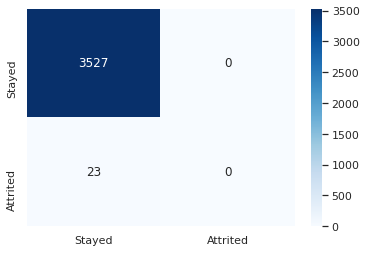

In [36]:
from sklearn.metrics import confusion_matrix
label_names=['Stayed','Attrited']
confusion_matrix = confusion_matrix(y_test, y_pred)
cf_matrix = confusion_matrix
sns.set(font_scale=1.0)
sns.heatmap(cf_matrix, annot=True, yticklabels=label_names, xticklabels=label_names, fmt="g", cmap="Blues")

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      3527
        True       0.00      0.00      0.00        23

    accuracy                           0.99      3550
   macro avg       0.50      0.50      0.50      3550
weighted avg       0.99      0.99      0.99      3550



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



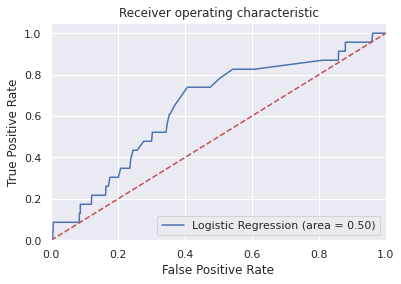

In [39]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
sns.set(font_scale=1.0)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(log_test_data))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(log_test_data)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [48]:
#testing a different threshold value - default is 0.5
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

y_pred_log = (logreg.predict_proba(X_test.select_dtypes(include=num))[:,1] >= 0.4).astype(bool) # set threshold as 0.4

#confusion matrix
cf_matrix_log = metrics.confusion_matrix(y_test, y_pred_log)
sns.set(font_scale=1.0)
sns.heatmap(cf_matrix_log, annot=True, yticklabels=label_names, xticklabels=label_names, fmt="g", cmap="Blues")

ValueError: ignored

# Machine Learning Benchmarks

# Hyper Parameter Search using Sklearn Grid Search Method for RF,
Does RF only take numeric inputs?

In [40]:
#Try different loss functions check sample weight too
import sklearn
from sklearn.model_selection import GridSearchCV
rf_parameters = {'n_jobs':[1], 
                 'max_depth':[3,5],
                 'min_samples_split':[0.05,], 
                 'class_weight':["balanced",'balanced_subsample'],
                 'n_estimators':[50,100,500],
                 'max_features':[0.3,'auto'], 
                 'random_state':[42]
                 }
svc = sklearn.ensemble.RandomForestClassifier()
clf = GridSearchCV(svc, rf_parameters)
clf.fit(X_train.select_dtypes(include=num), y_train)
rf_results = pd.DataFrame.from_dict(clf.cv_results_)

# Random Forest Hyper Parameter Results

In [41]:
newdf = pd.DataFrame.from_dict(clf.cv_results_['params'])
result = pd.concat([newdf,rf_results], axis=1, join='inner')
result.sort_values('rank_test_score', ascending=True)

,class_weight,max_depth,max_features,min_samples_split,n_estimators,n_jobs,random_state,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,param_n_jobs,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
21,balanced_subsample,5,auto,0.05,50,1,42,0.174367,0.006937,0.009105,0.000382,balanced_subsample,5,auto,0.05,50,1,42,"{'class_weight': 'balanced_subsample', 'max_de...",0.972403,0.964286,0.964286,0.954545,0.391234,0.849351,0.229128,1
6,balanced,5,0.3,0.05,50,1,42,0.120676,0.005078,0.008850,0.000285,balanced,5,0.3,0.05,50,1,42,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.962662,0.969156,0.967532,0.965909,0.381494,0.849351,0.233938,2
11,balanced,5,auto,0.05,500,1,42,1.162248,0.036313,0.075193,0.001784,balanced,5,auto,0.05,500,1,42,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.969156,0.972403,0.957792,0.957792,0.386364,0.848701,0.231244,3
18,balanced_subsample,5,0.3,0.05,50,1,42,0.173777,0.004784,0.009034,0.000276,balanced_subsample,5,0.3,0.05,50,1,42,"{'class_weight': 'balanced_subsample', 'max_de...",0.965909,0.967532,0.964286,0.964286,0.381494,0.848701,0.233607,3
23,balanced_subsample,5,auto,0.05,500,1,42,1.703278,0.022823,0.075256,0.001802,balanced_subsample,5,auto,0.05,500,1,42,"{'class_weight': 'balanced_subsample', 'max_de...",0.967532,0.972403,0.956169,0.959416,0.386364,0.848377,0.231078,5
19,balanced_subsample,5,0.3,0.05,100,1,42,0.355753,0.020146,0.016565,0.000886,balanced_subsample,5,0.3,0.05,100,1,42,"{'class_weight': 'balanced_subsample', 'max_de...",0.969156,0.967532,0.957792,0.961039,0.384740,0.848052,0.231693,6
7,balanced,5,0.3,0.05,100,1,42,0.238599,0.005406,0.016227,0.000779,balanced,5,0.3,0.05,100,1,42,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.964286,0.967532,0.961039,0.959416,0.386364,0.847727,0.230699,7
9,balanced,5,auto,0.05,50,1,42,0.119190,0.004238,0.009129,0.000655,balanced,5,auto,0.05,50,1,42,"{'class_weight': 'balanced', 'max_depth': 5, '...",0.969156,0.957792,0.962662,0.957792,0.391234,0.847727,0.228285,7
20,balanced_subsample,5,0.3,0.05,500,1,42,1.744596,0.015113,0.076044,0.005449,balanced_subsample,5,0.3,0.05,500,1,42,"{'class_weight': 'balanced_subsample', 'max_de...",0.969156,0.972403,0.956169,0.956169,0.384740,0.847727,0.231588,7
22,balanced_subsample,5,auto,0.05,100,1,42,0.338659,0.008375,0.017098,0.001240,balanced_subsample,5,auto,0.05,100,1,42,"{'class_weight': 'balanced_subsample', 'max_de...",0.969156,0.962662,0.961039,0.956169,0.383117,0.846429,0.231693,10


# Using the best results of the Hyper Parameter Search on the Test Data

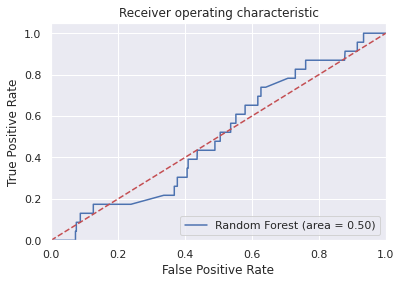

              precision    recall  f1-score   support

      Stayed       0.99      0.92      0.95      3527
    Attrited       0.01      0.09      0.01        23

    accuracy                           0.91      3550
   macro avg       0.50      0.50      0.48      3550
weighted avg       0.99      0.91      0.95      3550



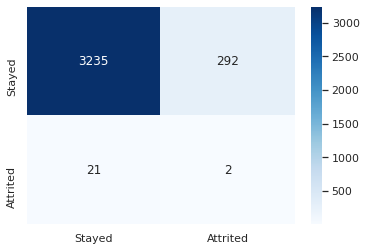

In [43]:
from sklearn import metrics
clf1 = RandomForestClassifier(**clf.best_params_) #defining the algorithm
#Fitting the Data
clf1.fit(X_train.select_dtypes(include=num), y_train)

#ROC Curve
RF_roc_auc = roc_auc_score(y_test, clf1.predict(X_test.select_dtypes(include=num)))
fpr, tpr, thresholds = roc_curve(y_test, clf1.predict_proba(X_test.select_dtypes(include=num))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % RF_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

#defining the predicted data and the list for the label names
y_pred = clf1.predict(X_test.select_dtypes(include=num))
label_names = ["Stayed", "Attrited"]

#Creating the confustion matrix
cf_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.0)
sns.heatmap(cf_matrix, annot=True, yticklabels=label_names, xticklabels=label_names, fmt="g", cmap="Blues")

#Creating confustion matrix for the train set
#cf1_matrix = metrics.confusion_matrix(y_train, clf1.predict(X_train.select_dtypes(include=num)))
#sns.heatmap(cf1_matrix, annot=True, yticklabels=label_names, xticklabels=label_names, fmt="g")

#Creating the full statistical report   
print(classification_report(y_test, y_pred, target_names=label_names))

# Testing different threshold values

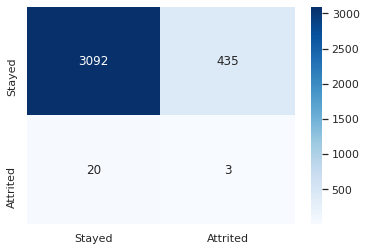

In [45]:
#testing a different threshold value - default is 0.5
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

y_pred2 = (clf1.predict_proba(X_test.select_dtypes(include=num))[:,1] >= 0.4).astype(bool) # set threshold as 0.4

#confusion matrix
cf_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
sns.set(font_scale=1.0)
sns.heatmap(cf_matrix2, annot=True, yticklabels=label_names, xticklabels=label_names, fmt="g", cmap="Blues")


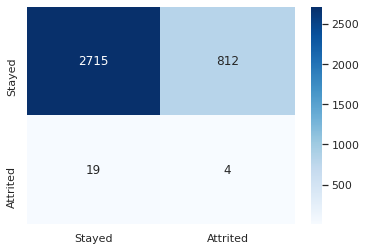

In [46]:
#testing a different threshold value - default is 0.5
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

y_pred2 = (clf1.predict_proba(X_test.select_dtypes(include=num))[:,1] >= 0.3).astype(bool) # set threshold as 0.3

#confusion matrix
cf_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
sns.set(font_scale=1.0)
sns.heatmap(cf_matrix2, annot=True, yticklabels=label_names, xticklabels=label_names, fmt="g", cmap="Blues")


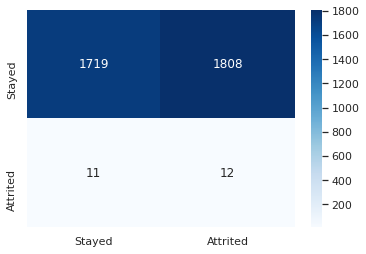

In [47]:
#testing a different threshold value - default is 0.5
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

y_pred2 = (clf1.predict_proba(X_test.select_dtypes(include=num))[:,1] >= 0.2).astype(bool) # set threshold as 0.2

#confusion matrix
cf_matrix2 = metrics.confusion_matrix(y_test, y_pred2)
sns.set(font_scale=1.0)
sns.heatmap(cf_matrix2, annot=True, yticklabels=label_names, xticklabels=label_names, fmt="g", cmap="Blues")


# Scatter Plot of Feature Importance Determined from RF Model

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = clf1.feature_importances_,
    x = X_train.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = clf1.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = X_train.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    titlefont=dict(
            size=40),
    hovermode= 'closest',
     xaxis= dict(
         title = 'Question Number',
         titlefont=dict(size=30),
         ticklen= 1,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        titlefont=dict(size=30),
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterrf1')
fig.show(renderer="colab")

#Ranking of important questions for RF

In [ ]:
#Here are the most important questions according to the RF algorithm

rf_importances = clf1.feature_importances_
rf_index = surveyPd.select_dtypes(include=num).columns.values 


featureimportance_df = pd.DataFrame({'Question Number': rf_index, 'Feature Importance': rf_importances}, columns=['Question Number', 'Feature Importance'])
fi_df = featureimportance_df.sort_values(by=['Feature Importance'], ascending=False)
fi_df

top_five = fi_df.head(n=5)
print(top_five)

question_column = top_five.loc[:,'Question Number']
imp_questions = question_column.values

#returning the 5 most important questions

print("The most important questions are: ")

for i in imp_questions:
  print(trainQuestions[int(i)])



   Question Number  Feature Importance
21              21            0.168980
20              20            0.117202
13              13            0.113431
18              18            0.108540
19              19            0.079383
The most important questions are: 
How likely is it you would recommend the company as a good place to work?
I enjoy working on my day to day tasks and assignments.
My job makes good use of my skills and abilities.
I intend to stay with the company for at least the next twelve months.
I enjoy working for my company.


## Hyper-Parameter Search for RF (K-Fold Cross Validation)



In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

#scores = cross_val_score(clf, surveyPd.loc[:,0:38], surveyPd[39], cv=5)
scores = cross_val_score(clf1, X_train.select_dtypes(include=num), y_train,cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
# from sklearn.model_selection import cross_val_predict
# predicted = cross_val_predict(clf1, surveyPd.loc[:,0:38], surveyPd[39], cv=10)
# predicted

0.82 accuracy with a standard deviation of 0.23


# Hyper Parameter Search using Sklearn Grid Search Method for Gradient Boost

In [ ]:
#Trying out Gradient Boosting
#importing
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn import metrics

#setting the gradient boosting parameter -- come back later if we need to change anything other than n_estimators
gbm = GradientBoostingClassifier()

# Hyper Parameter Search using Sklearn Grid Search Method for Gradient Boost

In [ ]:
from sklearn.model_selection import GridSearchCV
gb_parameters = {
    "n_estimators":[50,100], 
    'max_features':['auto','sqrt'],
    "max_depth":[1,3,5],
    "random_state":[42],
    "learning_rate":[0.1,0.25],
    "loss": ['deviance', 'exponential']
}

gbm1 = GridSearchCV(gbm, gb_parameters)
gbm1.fit(X_train.select_dtypes(include=num),y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_n...
                 

# Gradient Boost Hyper Parameter Search Results

In [ ]:
gbm_results = pd.DataFrame.from_dict(gbm1.cv_results_)
newdf = pd.DataFrame.from_dict(gbm1.cv_results_['params'])
result = pd.concat([newdf,gbm_results], axis=1, join='inner')
result.sort_values('rank_test_score', ascending=True)

,learning_rate,loss,max_depth,max_features,n_estimators,random_state,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_max_features,param_n_estimators,param_random_state,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.10,deviance,1,auto,50,42,0.096839,0.005876,0.001890,0.000059,0.1,deviance,1,auto,50,42,"{'learning_rate': 0.1, 'loss': 'deviance', 'ma...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
42,0.25,exponential,3,sqrt,50,42,0.094366,0.003537,0.002319,0.000148,0.25,exponential,3,sqrt,50,42,"{'learning_rate': 0.25, 'loss': 'exponential',...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
39,0.25,exponential,1,sqrt,100,42,0.116983,0.002940,0.002214,0.000113,0.25,exponential,1,sqrt,100,42,"{'learning_rate': 0.25, 'loss': 'exponential',...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
38,0.25,exponential,1,sqrt,50,42,0.060173,0.003478,0.001879,0.000016,0.25,exponential,1,sqrt,50,42,"{'learning_rate': 0.25, 'loss': 'exponential',...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
37,0.25,exponential,1,auto,100,42,0.201571,0.002246,0.002263,0.000174,0.25,exponential,1,auto,100,42,"{'learning_rate': 0.25, 'loss': 'exponential',...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
36,0.25,exponential,1,auto,50,42,0.099595,0.000995,0.001881,0.000086,0.25,exponential,1,auto,50,42,"{'learning_rate': 0.25, 'loss': 'exponential',...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
27,0.25,deviance,1,sqrt,100,42,0.097242,0.002576,0.002059,0.000074,0.25,deviance,1,sqrt,100,42,"{'learning_rate': 0.25, 'loss': 'deviance', 'm...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
26,0.25,deviance,1,sqrt,50,42,0.049272,0.000351,0.001821,0.000051,0.25,deviance,1,sqrt,50,42,"{'learning_rate': 0.25, 'loss': 'deviance', 'm...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
46,0.25,exponential,5,sqrt,50,42,0.154574,0.002555,0.002852,0.000226,0.25,exponential,5,sqrt,50,42,"{'learning_rate': 0.25, 'loss': 'exponential',...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1
22,0.10,exponential,5,sqrt,50,42,0.157467,0.002443,0.002853,0.000241,0.1,exponential,5,sqrt,50,42,"{'learning_rate': 0.1, 'loss': 'exponential', ...",0.985276,0.985276,0.985258,0.985258,0.396806,0.867575,0.235384,1


# Fitting the best parameters on test data using Gradient Boost

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

       False       0.99      1.00      0.99      4012
        True       0.00      0.00      0.00        60

    accuracy                           0.99      4072
   macro avg       0.49      0.50      0.50      4072
weighted avg       0.97      0.99      0.98      4072

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      4566
        True       0.00      0.00      0.00        43

    accuracy                           0.99      4609
   macro avg       0.50      0.50      0.50      4609
weighted avg       0.98      0.99      0.99      4609



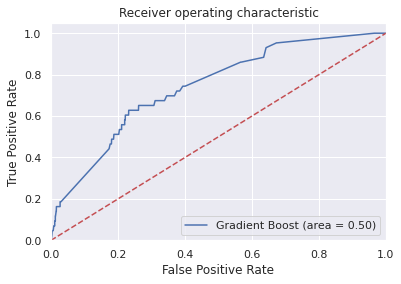

Confusion Matrix - Training Dataset
Predicted  False   All
True                  
False       4566  4566
True          43    43
All         4609  4609


In [ ]:
from sklearn import metrics
#Fitting the model
gbm2 = GradientBoostingClassifier(**gbm1.best_params_)
gbm2.fit(X_train.select_dtypes(include=num), y_train)

#Predicting based on the test set
y_grad_predicted = gbm2.predict(X_test.select_dtypes(include=num))

#printing full metrics report
#print(metrics.classification_report(y_test, y_grad_predicted))
print(classification_report(y_train, gbm2.predict(X_train.select_dtypes(include=num))))     
print(classification_report(y_test, gbm2.predict(X_test.select_dtypes(include=num))))


GB_roc_auc = roc_auc_score(y_test, gbm2.predict(X_test.select_dtypes(include=num)))
fpr, tpr, thresholds = roc_curve(y_test, gbm2.predict_proba(X_test.select_dtypes(include=num))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Gradient Boost (area = %0.2f)' % GB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Gradient Boost_ROC')
plt.show()

print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_test.ravel(), y_grad_predicted, rownames = ['True'], colnames = ['Predicted'], margins = True))

# Feature Importance Visual as Determined by Gradient Boost Model

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = gbm2.feature_importances_,
    x = surveyPd.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = gbm2.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = surveyPd.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boost Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 1,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scattergb')
fig.show(renderer="colab")

In [ ]:
#Here are the most important questions according to the GB algorithm

gb_importances = gbm2.feature_importances_
gb_index = surveyPd.select_dtypes(include=num).columns.values 
#new_index = np.delete(rf_index, -1)

featureimportance_df = pd.DataFrame({'Question Number': gb_index, 'Feature Importance': gb_importances}, columns=['Question Number', 'Feature Importance'])
fi_df = featureimportance_df.sort_values(by=['Feature Importance'], ascending=False)
fi_df

top_five = fi_df.head(n=5)
print(top_five)

question_column = top_five.loc[:,'Question Number']

imp_questions = question_column.values

#returning the 5 most important questions

#print(imp_questions)
print('The questions are:')
for i in imp_questions:
  print(trainQuestions[int(i)])



# K Fold Cross Validation on the Gradient Boost Model

In [ ]:
scores = cross_val_score(gbm2, X_train.select_dtypes(include=num), y_train,cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(gbm2, X_train.select_dtypes(include=num), y_train, cv=10)
predicted

# Hyper Parameter Search using Sklearn Grid Search Method for Xtreme Gradient Boost

In [ ]:
from xgboost import XGBClassifier

xgm = XGBClassifier()

#try a more different learning rates and other parameter values
xgm_parameters = {
    "n_estimators":[50,100,200], 
    'max_features':[1, 10,'auto','sqrt'],
    "max_depth":[1,3,5],
    "random_state":[42],
    "learning_rate":[0.05,0.1,0.25],
    
}
xgm1 = GridSearchCV(xgm, xgm_parameters)
xgm1.fit(X_train.select_dtypes(include=num),y_train.values.ravel())

# Hyper Parameter Experiment Results using XGB

In [ ]:
xgm_results = pd.DataFrame.from_dict(xgm1.cv_results_)
newdf = pd.DataFrame.from_dict(xgm1.cv_results_['params'])
result = pd.concat([newdf,xgm_results], axis=1, join='inner')
result.sort_values('rank_test_score', ascending=True)

# Testing Best Parameters from HP search on Test Data using XGB Model

In [ ]:
#XGboost
from xgboost import XGBClassifier
xgm2 = XGBClassifier(**xgm1.best_params_)

xgm2.fit(X_train.select_dtypes(include=num), y_train)

y_xg_predicted = xgm2.predict(X_test.select_dtypes(include=num))

#print(metrics.classification_report(y_test, y_xg_predicted))
print(classification_report(y_train, gbm2.predict(X_train.select_dtypes(include=num))))     
print(classification_report(y_test, gbm2.predict(X_test.select_dtypes(include=num))))

XGB_roc_auc = roc_auc_score(y_test, xgm2.predict(X_test.select_dtypes(include=num)))
fpr, tpr, thresholds = roc_curve(y_test, xgm2.predict_proba(X_test.select_dtypes(include=num))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='X Gradient Boost (area = %0.2f)' % XGB_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('XGB_ROC')
plt.show()

print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_test.ravel(), y_xg_predicted, rownames = ['True'], colnames = ['Predicted'], margins = True))

# Feature Importance Visual from XGB Model

In [ ]:
# Scatter plot 
trace = go.Scatter(
    y = xgm2.feature_importances_,
    x = surveyPd.columns.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 13,
        #size= rf.feature_importances_,
        #color = np.random.randn(500), #set color equal to a variable
        color = xgm2.feature_importances_,
        colorscale='Portland',
        showscale=True
    ),
    text = surveyPd.columns.values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'XG Boost Feature Importance',
    hovermode= 'closest',
     xaxis= dict(
         ticklen= 1,
         showgrid=False,
        zeroline=False,
        showline=False
     ),
    yaxis=dict(
        title= 'Feature Importance',
        showgrid=False,
        zeroline=False,
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterxg')
fig.show(renderer="colab")

In [ ]:
#Here are the most important questions according to the RF algorithm

xg_importances = xgm2.feature_importances_
xg_index = surveyPd.select_dtypes(include=num).columns.values 
#new_index = np.delete(rf_index, -1)

featureimportance_df = pd.DataFrame({'Question Number': xg_index, 'Feature Importance': xg_importances}, columns=['Question Number', 'Feature Importance'])
fi_df = featureimportance_df.sort_values(by=['Feature Importance'], ascending=False)
fi_df

top_five = fi_df.head(n=5)
print(top_five)

question_column = top_five.loc[:,'Question Number']

imp_questions = question_column.values

#returning the 5 most important questions

print(imp_questions)

for i in imp_questions:
  print(trainQuestions[int(i)])



# K Fold Cross Validation on the XGB Model

In [ ]:
scores = cross_val_score(xgm2, X_train.select_dtypes(include=num), y_train,cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(xgm2, X_train.select_dtypes(include=num), y_train, cv=10)
predicted

# AUTO KERAS MODELLING

# Using Auto Keras to build a Classification Model


In [ ]:

#AutoKeras
#Try this with a different loss function

import logging
tf.get_logger().setLevel(logging.ERROR)

from sklearn.metrics import classification_report, confusion_matrix
import autokeras as ak


#fitting the model
alf = ak.StructuredDataClassifier(max_trials=5, loss="binary_crossentropy")
alf.fit(X_train,y_train, verbose=1, epochs=10)

alf_eval = alf.evaluate(X_train, y_train)
alf_eval


#alf_predict = alf.predict(X_test)
#cm = confusion_matrix(y_test,alf_predict)
#sns.heatmap(cm, annot=True)

model = alf.export_model()
model.summary()


Keras

# Class Weight Experiment with Keras

In [ ]:
#checking the shape of our data

print(X_train.shape)
print(y_train.shape)

In [ ]:
counts = np.bincount(y_train)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

#Determining the weight needed for each class
##This could be changed if we wished to weight the attriting class even more strongly
weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

print("Weight for neg class", weight_for_0)
print("Weight for attrit class", weight_for_1)

In [ ]:
#trying regular keras based on this credit card fraud example- https://keras.io/examples/structured_data/imbalanced_classification/
#class weight serves to make the loss function pay more attention to a miss
from tensorflow import keras

#defining the model
model = keras.Sequential(
    [
        keras.layers.Dense(
            32, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation="sigmoid")
    ]
)
model.summary()


In [ ]:
from sklearn.utils import class_weight

metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics=metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("atrrit_model_at_epoch_{epoch}.h5")]
class_weight = {0:weight_for_0, 1:weight_for_1} #adjust this to determine the penalty for missing

model.fit(X_train,y_train,
    batch_size=2048,
    epochs=10,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    class_weight=class_weight

)


In [ ]:
# np.set_printoptions(precision=4, suppress=True)
from sklearn import metrics
# eval_results = model.evaluate(X_test, y_test, verbose=0) 

# print("\nLoss, accuracy on test data: ")
# print("%0.4f, %0.2f%%" % (eval_results[0], \
#   eval_results[1]*100))

keras_predicted = model.predict(X_test)


y_pred = np.argmax(keras_predicted, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

print('Classification Report')
target_names = ['Stay','Attrit']
print(classification_report(y_test, y_pred, target_names=target_names))

#print(metrics.classification_report(y_test, keras_predicted))


# Appendix



```
# This is formatted as code
```

Questions that were asked to the recipients of Client #1's survey

In [ ]:
q_cols = ['general empl satisfaction',
 'recommend empl unit to friend',
 'motivation of direct colleagues you are working with day to day? *Top 3',
 'My direct colleagues are coping well with the change and transformation in our division/function',
 'People in my team frequently go above and beyond the requirements of the job',
 'I am proud working for my company and gladly tell people about it',
 'I believe strongly in and support the future direction of my company',
 'I trust that my company takes action that balances the best interests of our people, business and clients',
 "My company's handling of this year’s challenges leaves me confident in our future success",
 "My company's future direction leaves me confident about my career opportunities here",
 'In my team we continuously use client feedback to improve our products/services',
 'In my team we have an ongoing dialogue about our clients and their requirements and expectations',
 'Compared to last year, our clients now view us as:',
 'My immediate manager creates an atmosphere of openness and trust',
 'I have confidence in my immediate manager',
 'I have confidence in the global senior management of [division]',
 'I have confidence in the senior management of [FUNCTION: Finance, HR, Technology, Operations, Marketing]',
 'I have confidence in my local/country senior management',
 'As a member of [FUNCTION: Finance, HR, Technology, Operations, Marketing] I am familiar with the overall objectives & strategies of my function',
 'I am familiar with the overall objectives & strategies of [division]',
 'I can clearly see how my own work contributes to the overall objectives & strategies of [division]',
 'In my team we work towards clear objectives',
 'In my team we make decisions rapidly when it is necessary',
 'In my team actions are taken quickly when decisions have been made',
 'Please rate the cooperation between different units within [division]',
 'Please rate the cooperation within [FUNCTION: Finance, HR, Technology, Operations, Marketing]',
 'Please rate the cooperation across the company as a whole',
 'In my team new ideas receive very strong support and encouragement',
 'I feel I can make my own decisions concerning my work',
 "I have seen action taken based on the results of last year's survey",
 'In my company diversity of skills, experiences, background and ways of working are recognized and appreciated',
 'My immediate manager treats all team members fairly, regardless of age, gender identity, sex, family status, race, national origin, nationality, religion, disability or sexual orientation',
 'My immediate manager effectively works with people who are different from them to achieve business results',
 'In my team we treat each other fairly, regardless of age, sex, gender identity, family status, race, national origin, nationality, religion, disability or sexual orientation',
 'I feel included in my team',
 'My company takes an interest in my well-being',
 'My work schedule allows me sufficient flexibility to meet my personal/family needs',
 'Career opportunities always go to the most qualified person regardless of age, gender identity, sex, family status, race, national origin, nationality, religion, disability or sexual orientation',
 'Is there anything else you want to share with us?']

#Catboost

In [ ]:
#one hot encoding is built into this model. do not need to use it in the preprocessing
from catboost import CatBoostClassifier, Pool
from sklearn import metrics
from catboost.utils import get_confusion_matrix

#train the model

train_dataset = Pool(data=X_train,
                     label=y_train)

eval_dataset = Pool(data=X_test,
                    label=y_test)


cbm = CatBoostClassifier(verbose=200, loss_function='Logloss', eval_metric='AUC',random_seed=42)

cbm.fit(train_dataset, use_best_model=True, eval_set=eval_dataset, plot=True)


cat_predict = cbm.predict(X_test)

print(cat_predict)

cm1 = get_confusion_matrix(cbm, Pool(X_train, y_train))
print(cm1)

cm2 = get_confusion_matrix(cbm, Pool(X_test, y_test))
print(cm2)

print(cbm.get_best_score())
print(cbm.get_best_iteration())

print("Count of trees in model = {}".format(cbm.tree_count_))


#Hyper Parameter Search using Sklearn Grid Search Method for SVM

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
svm_parameters = {'kernel':('linear', 'rbf'), 'C':[1,5]} #added a class weight
svc = svm.SVC()
clf2 = GridSearchCV(svc, svm_parameters)
clf2.fit(X_train, y_train)

# Hyper Parameter Results for SVM

---



In [ ]:
svm_results = pd.DataFrame.from_dict(clf2.cv_results_)
newdf = pd.DataFrame.from_dict(clf2.cv_results_['params'])
result = pd.concat([newdf,svm_results], axis=1, join='inner')
result

# Best Parameters Chosen for SVM on Test Data

In [ ]:
from sklearn import svm
clf3 = svm.SVC(**clf2.best_params_).fit(X_train, y_train)
clf3.score(X_test, y_test)
print(classification_report(y_train, clf3.predict(X_train)))
      
print(classification_report(y_test, clf3.predict(X_test)))

plot_roc_curve(clf3, X_test, y_test)
print('Confusion Matrix - Training Dataset')
print(pd.crosstab(y_test.ravel(),  clf3.predict(X_test), rownames = ['True'], colnames = ['Predicted'], margins = True))

# K-Fold Cross Validation of SVM Model

In [ ]:
scores = cross_val_score(clf3, X_train, y_train,cv=5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(clf3, X_train, y_train, cv=10)
predicted